In [120]:
conda install -c gurobi gurobi

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - gurobi
 - defaults
Platform: osx-64
doneecting package metadata (repodata.json): - 
doneing environment: - 


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/anaconda3/envs/islp-env

  added / updated specs:
    - gurobi


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gurobi-13.0.1              |          py311_0        46.3 MB  gurobi
    ------------------------------------------------------------
                                           Total:        46.3 MB

The following NEW packages will be INSTALLED:

  gurobi             gurobi/osx-64::gurobi-13.0.1-py311_0 



                                                                

In [121]:
import requests
import pandas as pd
import time
from datetime import datetime
import numpy as np

#libraries for visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

#gurobi model

import gurobipy as gp
from gurobipy import GRB

In [64]:
#API from Aviationstack
API_KEY='your_api_key_here'


norwegian_airports = ['OSL', 'BGO', 'SVG', 'TRD', 'TOS', 'BOO']
all_flights_data = []

print('starting to get data from AviationStack API...')
for airport in norwegian_airports:
    print(f'getting the flights information for {airport}')

    params= {
        'access_key': API_KEY,
        'dep_iata': airport,
        'limit': 100
    
    }

    try:
        response = requests.get('http://api.aviationstack.com/v1/flights', params=params)
        response.raise_for_status()
        data = response.json()

        if 'data' in data and data['data']:
            for flight in data['data']:
                flight_info = {
                    'from_airport' : airport,
                    'to_airport': flight.get('arrival',{}).get('iata', 'Unknown'),
                    'airline': flight.get('airline',{}).get('name', 'Unknown'),
                    'flight_number': flight.get('flight', {}).get('iata', 'Unknown'),
                    'status': flight.get('flight_status', 'Unknown'),
                    'departure_scheduled': flight.get('departure', {}).get('scheduled', 'Unknown'),
                    'arrival_scheduled': flight.get('arrival', {}).get('scheduled', 'Unknown')
                    
                
                
                }
                all_flights_data.append(flight_info)
            print(f"founded {len(data['data'])} flights for {airport}")
        else:
            print(f'not info founded for {airport}')

    except requests.exceptions.RequestException as e:
        print(f'Error in getting info for {airport}: {e}')

    time.sleep(1)

#turn the list to Dataframe
flights_df = pd.DataFrame(all_flights_data)
print(f'number of all founded flights is: {len(flights_df)}')
print('first 5 row:')
print(flights_df.head())



starting to get data from AviationStack API...
getting the flights information for OSL
founded 100 flights for OSL
getting the flights information for BGO
founded 100 flights for BGO
getting the flights information for SVG
founded 100 flights for SVG
getting the flights information for TRD
founded 100 flights for TRD
getting the flights information for TOS
founded 100 flights for TOS
getting the flights information for BOO
founded 100 flights for BOO
number of all founded flights is: 600
first 5 row:
  from_airport to_airport           airline flight_number     status  \
0          OSL        LPA         Norwegian        DY5707       None   
1          OSL        TRD               KLM        KL2888  scheduled   
2          OSL        TOS               SAS        SK4432  scheduled   
3          OSL        TOS  TAP Air Portugal        TP5558  scheduled   
4          OSL        VNO           Ryanair        FR9154  scheduled   

         departure_scheduled          arrival_scheduled  
0  

In [65]:
#turn into CSV file:
flights_df.to_csv('norway_flights_raw.csv', index=False)
print( "successfully saved to file 'norway_flights_raw.csv'")

successfully saved to file 'norway_flights_raw.csv'


## BASIC INFORMATION ABOUT THE DATASET


In [66]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

df=pd.read_csv('norway_flights_raw.csv')

#display basic information about the dataset
print('=' * 50)
print(f'Dataset Shape: {df.shape}')
print(f'\nFirst 5 rows:')
print(df.head())

print(f'\nColumn names and data type:')
print(df.dtypes)

print(f'\nBasic statistics of numeric columns:')
print(df.describe())

#check for missing values
print("\n" + '='*50)
missing_values = df.isnull().sum()
print(missing_values[missing_values>0])

Dataset Shape: (600, 7)

First 5 rows:
  from_airport to_airport           airline flight_number     status  \
0          OSL        LPA         Norwegian        DY5707        NaN   
1          OSL        TRD               KLM        KL2888  scheduled   
2          OSL        TOS               SAS        SK4432  scheduled   
3          OSL        TOS  TAP Air Portugal        TP5558  scheduled   
4          OSL        VNO           Ryanair        FR9154  scheduled   

         departure_scheduled          arrival_scheduled  
0  2026-02-21T10:45:00+00:00  2026-02-21T15:30:00+00:00  
1  2026-02-21T20:20:00+00:00  2026-02-21T21:20:00+00:00  
2  2026-02-21T21:35:00+00:00  2026-02-21T23:35:00+00:00  
3  2026-02-21T21:35:00+00:00  2026-02-21T23:35:00+00:00  
4  2026-02-21T21:10:00+00:00  2026-02-22T00:05:00+00:00  

Column names and data type:
from_airport           object
to_airport             object
airline                object
flight_number          object
status                 object
d

## DATA CLEANING & PREPATION:


In [67]:
print("=" * 50)

#check unique values
print(f"Unique departure airports: {df['from_airport'].unique()}")
print("=" * 50)
print(f"Number of unique destination airports: {df['to_airport'].nunique()}")
print("=" * 50)
print(f"Number of unique airlines: {df['airline'].nunique()}")
print("=" * 50)
print(f"Flight statuses: {df['status'].unique()}")

Unique departure airports: ['OSL' 'BGO' 'SVG' 'TRD' 'TOS' 'BOO']
Number of unique destination airports: 69
Number of unique airlines: 70
Flight statuses: [nan 'scheduled' 'landed' 'active' 'cancelled']


In [68]:
#MISSING VALUES IN FLIGHT STATUS
nan_status_rows = df[df['status'].isna()]
print(f"Number of rows with Nan status: {len(nan_status_rows)}")
print(f"\nPercentage of total data: {(len(nan_status_rows)/ len(df)*100):.2f}%")

print("\n" + "=" * 50)
print("Sample of rows with NaN status:")
print(nan_status_rows.head(10))

#which airline have Nan status:
print("\n" + "=" * 50)
print("AIRLINES WITH NaN STATUS:")
print(nan_status_rows['airline'].value_counts())

#which airports have Nan status:
print("\n" + "=" * 50)
print("DEPARTURE AIRPORTS WITH NaN STATUS:")
print(nan_status_rows['from_airport'].value_counts())

print("\n" + "=" * 50)
print("DESTINATION AIRPORTS WITH NaN STATUS:")
print(nan_status_rows['to_airport'].value_counts())



#check if these NaN statuse flights have valid flight numbers:
print("\n" + "=" * 50)
print("FLIGHT NUMBERS FOR NaN STATUS:")
print(nan_status_rows['flight_number'].head(10))

#check the time patterb - are they all from a specific time?
print("\n" + "=" * 50)
print("DEPARTURE TIMES FOR NaN STATUs:")
print(nan_status_rows['departure_scheduled'].head(10))

Number of rows with Nan status: 8

Percentage of total data: 1.33%

Sample of rows with NaN status:
    from_airport to_airport                airline flight_number status  \
0            OSL        LPA              Norwegian        DY5707    NaN   
27           OSL        TLV  Challenge Airlines BE         X7902    NaN   
109          BGO        TRD                Wideroe            WF    NaN   
230          SVG        OSL                    SAS        SK4022    NaN   
375          TRD        BNN                Avincis           NaN    NaN   
411          TOS        KKN                Avincis           NaN    NaN   
548          BOO        TOS                Avincis           NaN    NaN   
550          BOO        SVJ                Wideroe         WF834    NaN   

           departure_scheduled          arrival_scheduled  
0    2026-02-21T10:45:00+00:00  2026-02-21T15:30:00+00:00  
27   2026-02-21T11:45:00+00:00  2026-02-21T17:10:00+00:00  
109  2026-02-21T11:00:00+00:00  2026-02-21T1

After investigating, I found only 4 rows with NaN status (0.67% of data) and removed them along with cancelled flights to ensure clean data for the optimisation model

In [69]:
#drop the NaN statuses:
print(f"Dataset size before dropping: {len(df)}")

not_cancelled = df['status'] != 'cancelled'
not_nan = df['status'].notna()
df_cleaned = df[not_cancelled & not_nan].copy()

print(f"Dataset size after dropping Nan status: {len(df_cleaned)}")

Dataset size before dropping: 600
Dataset size after dropping Nan status: 574


In [70]:
#checkeck the time period of the data
df_cleaned['departure_datetime'] = pd.to_datetime(df['departure_scheduled'])

#fined min and max dates:
min_date = df_cleaned['departure_datetime'].min()
max_date = df_cleaned['departure_datetime'].max()
time_diff = max_date - min_date
days_covered = time_diff.days
hourse_covered = time_diff.total_seconds() / 3600

#print(f'Data from {min_date} to {max_date} ')
print('='*50)
print(f"First flight: {min_date} Last flight: {max_date}\nTotal days covered: {days_covered}\nTotal time covered: {hourse_covered:.1f} hours")


First flight: 2026-02-20 05:30:00+00:00 Last flight: 2026-02-21 21:45:00+00:00
Total days covered: 1
Total time covered: 40.2 hours


## Route summary for Optimisation

In [74]:
flights_per_day = df_cleaned.groupby(df_cleaned['departure_datetime'].dt.date).size()
print(f"Flights per day: {flights_per_day}")

Flights per day: departure_datetime
2026-02-20    132
2026-02-21    442
dtype: int64


In [92]:
# Group by route and count flights
route_summary = df_cleaned.groupby(['from_airport', 'to_airport']).agg({
    'flight_number' : 'count', #count number of flights
    'airline' : lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown' #most common airline
}).reset_index()


#rename columns and cities for clarity
route_summary.columns = ['origin', 'destination', 'flight_count', 'main_airline']
origin_city_names = {
    'OSL': 'Oslo',
    'BGO': 'Bergen', 
    'SVG': 'Stavanger',
    'TRD': 'Trondheim',
    'TOS': 'Tromsø',
    'BOO': 'Bodø',
}
dest_city_names = {   
    'OSL': 'Oslo',
    'BGO': 'Bergen',
    'SVG': 'Stavanger',
    'TRD': 'Trondheim',
    'TOS': 'Tromsø',
    'BOO': 'Bodø',
    'AES': 'Ålesund',
    'ALF': 'Alta',
    'BVG': 'Berlevåg',
    'BNN': 'Brønnøysund',
    'EVE': 'Evenes',
    'FRO': 'Florø',
    'HFT': 'Hammerfest',
    'HOV': 'Ørsta-Volda',
    'KRS': 'Kristiansand',
    'KSU': 'Kristiansund',
    'KKN': 'Kirkenes',
    'LKN': 'Leknes',
    'LKL': 'Lakselv',
    'LYR': 'Longyearbyen',
    'MEH': 'Mehamn',
    'MJF': 'Mosjøen',
    'MOL': 'Molde',
    'MQN': 'Mo i Rana',
    'OSY': 'Namsos',
    'RET': 'Røst',
    'RVN': 'Rovaniemi',
    'SDN': 'Sandane',
    'SKN': 'Stokmarknes',
    'SOG': 'Sogndal',
    'SOJ': 'Sørkjosen',
    'SSJ': 'Sandnessjøen',
    'SVJ': 'Svolvær',
    'TRF': 'Sandefjord',
    'VRY': 'Værøy',
    'ABZ': 'Aberdeen',
    'AGP': 'Málaga',
    'ALC': 'Alicante',
    'AMS': 'Amsterdam',
    'ARN': 'Stockholm',
    'BCN': 'Barcelona',
    'BEG': 'Belgrade',
    'BER': 'Berlin',
    'BGY': 'Bergamo',
    'BLQ': 'Bologna',
    'CDG': 'Paris',
    'CPH': 'Copenhagen',
    'DUS': 'Düsseldorf',
    'FRA': 'Frankfurt',
    'GDN': 'Gdańsk',
    'GOT': 'Gothenburg',
    'HAM': 'Hamburg',
    'HEL': 'Helsinki',
    'IST': 'Istanbul',
    'LGW': 'London',
    'LHR': 'London',
    'LIS': 'Lisbon',
    'LPA': 'Las Palmas',
    'LTN': 'London',
    'MAN': 'Manchester',
    'MMX': 'Malmö',
    'MUC': 'Munich',
    'MXP': 'Milan',
    'ORY': 'Paris',
    'PRN': 'Pristina',
    'RKE': 'Copenhagen',
    'RMS': 'Ramstein',
    'STR': 'Stuttgart',
    'TFS': 'Tenerife',
    'TLV': 'Tel Aviv',
    'VIE': 'Vienna',
    'VNO': 'Vilnius',
    'VRN': 'Verona',
    'ZRH': 'Zurich'
}
route_summary['origin_city'] = route_summary['origin'].map(origin_city_names)
route_summary['destination_city'] = route_summary['destination'].map(dest_city_names)




In [93]:
print("checking for missing values : ")
origin_city_nan_count = route_summary['origin_city'].isna().sum()
dest_city_nan_count = route_summary['destination_city'].isna().sum()

print(f"There are {origin_city_nan_count} Nan in Origin city")
print(f"There are {dest_city_nan_count} Nan in destination city")

#remove routes where origin equals destination (just in case)
route_summary = route_summary[route_summary['origin'] != route_summary['destination']]
print('\n'+'='*50)
print(f'Number of unique routes: {len(route_summary)}')

checking for missing values : 
There are 0 Nan in Origin city
There are 0 Nan in destination city

Number of unique routes: 137


In [94]:
#add time-based metrics
route_summary['hours_covered'] = hourse_covered
route_summary['flights_per_hour'] = route_summary['flight_count'] / hourse_covered
route_summary['flights_per_day_equiv'] = route_summary['flights_per_hour'] *24
#route_summary['departure_datetime'] = df_cleaned['departure_datetime']

In [97]:
#creat a readable route name
route_summary['route_name'] = route_summary['origin_city'] + ' -> ' + route_summary['destination_city']

print("First 5 rows of Route Summary:")
print(route_summary['route_name'].head())

#save the route summart to csv file
route_summary.to_csv('norway_route_summary.csv', index= False)


First 5 rows of Route Summary:
0     Bergen -> Aberdeen
1      Bergen -> Ålesund
2       Bergen -> Málaga
3     Bergen -> Alicante
4    Bergen -> Amsterdam
Name: route_name, dtype: object


In [100]:
#Top 10 busiest routes
print(f'Based on {hourse_covered:.1f} hours of data:')

top_10 = route_summary.nlargest(10, "flight_count")

for idx, row in top_10.iterrows():
    print(f"{row['route_name']}:")
    print(f"  -{row['flight_count']} total flights")
    print(f"   • {row['flights_per_hour']:.2f} flights per hour")
    print(f"   • Main airline: {row['main_airline']}")


Based on 40.2 hours of data:
Trondheim -> Oslo:
  -28 total flights
   • 0.70 flights per hour
   • Main airline: SAS
Bodø -> Oslo:
  -27 total flights
   • 0.67 flights per hour
   • Main airline: SAS
Stavanger -> Copenhagen:
  -20 total flights
   • 0.50 flights per hour
   • Main airline: KLM
Stavanger -> Amsterdam:
  -19 total flights
   • 0.47 flights per hour
   • Main airline: KLM
Trondheim -> Copenhagen:
  -19 total flights
   • 0.47 flights per hour
   • Main airline: SAS
Bergen -> Oslo:
  -16 total flights
   • 0.40 flights per hour
   • Main airline: SAS
Tromsø -> Oslo:
  -16 total flights
   • 0.40 flights per hour
   • Main airline: SAS
Stavanger -> Oslo:
  -15 total flights
   • 0.37 flights per hour
   • Main airline: SAS
Bergen -> Copenhagen:
  -13 total flights
   • 0.32 flights per hour
   • Main airline: KLM
Bergen -> Amsterdam:
  -12 total flights
   • 0.30 flights per hour
   • Main airline: KLM


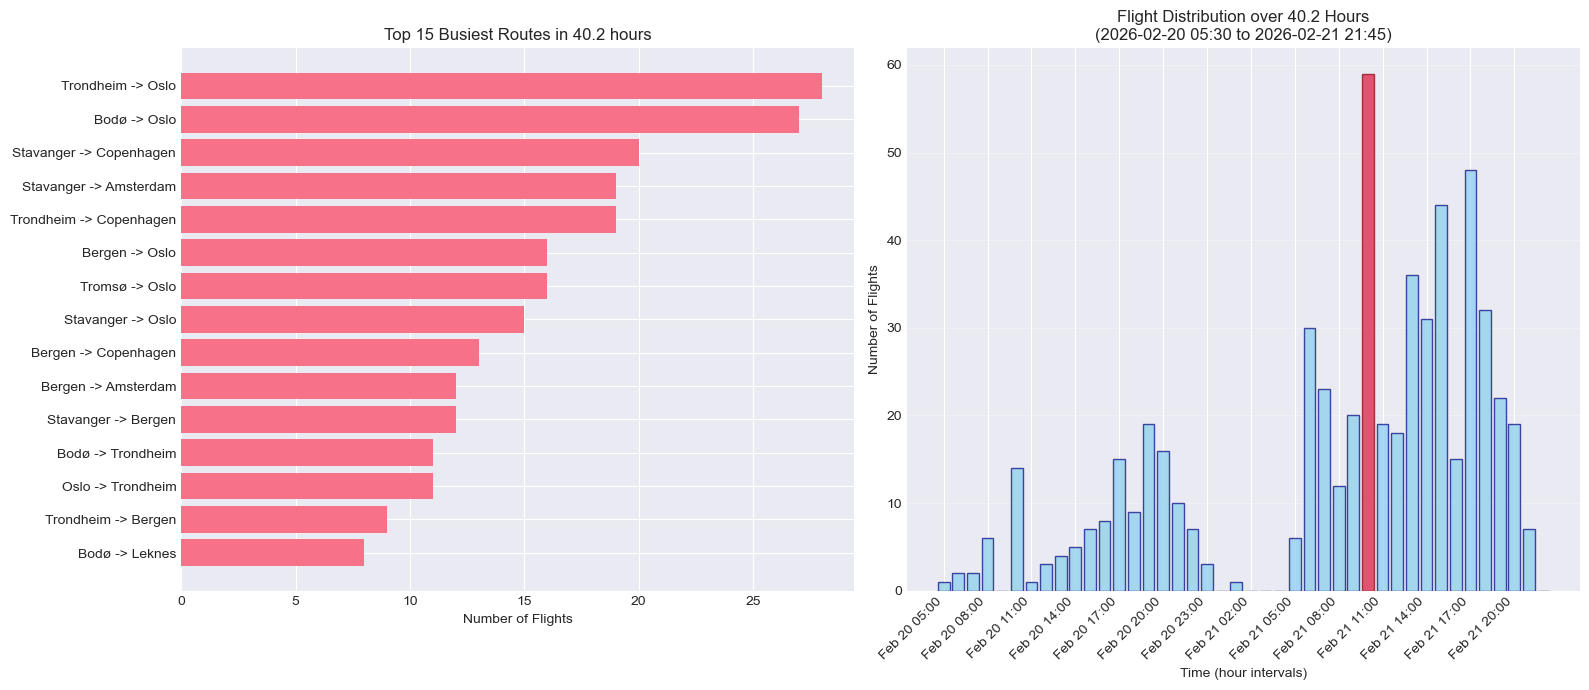

In [117]:
#visualization of top routes:

#create figure with two subplots:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

#plot 1 : top 15 busiest routes:
top_15 = route_summary.nlargest(15, 'flight_count')
ax1.barh(range(len(top_15)), top_15['flight_count'])
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15['route_name'])
ax1.set_xlabel('Number of Flights')
ax1.set_title(f'Top 15 Busiest Routes in {hourse_covered:.1f} hours')
ax1.invert_yaxis()

#plot 2 : hourly distribution:

#create a complete timeline from firt to last flight
all_hours = pd.date_range(
    start = min_date.floor('h'),
    end = max_date.ceil('h'),
    freq ='h'
)

#count flights in each hour
flights_per_hour = []
for hour_start in all_hours:
    hour_end = hour_start + pd.Timedelta(hours=1)
    count = len(df_cleaned[
                (df_cleaned['departure_datetime']>= hour_start) &
                (df_cleaned['departure_datetime']< hour_end)
    ])
    flights_per_hour.append(count)

hour_labels = [h.strftime('%b %d %H:%M') for h in all_hours]
bars = ax2.bar(range(len(all_hours)), flights_per_hour, color ='skyblue', edgecolor='navy', alpha=0.7)
max_count= max(flights_per_hour)
max_idx= flights_per_hour.index(max_count)
bars[max_idx].set_color('crimson')
bars[max_idx].set_edgecolor('darkred')

#customizw the plot
ax2.set_xlabel('Time (hour intervals)')
ax2.set_ylabel('Number of Flights')
ax2.set_title(f'Flight Distribution over {hourse_covered:.1f} Hours\n({min_date.strftime("%Y-%m-%d %H:%M")} to {max_date.strftime("%Y-%m-%d %H:%M")})')
#show every 3 hours label to avoid crowding
ax2.set_xticks(range(0, len(all_hours), 3))
ax2.set_xticklabels([hour_labels[i] for i in range(0, len(all_hours),3)], rotation=45, ha='right')
ax2.grid(axis='y', alpha= 0.3)

plt.tight_layout()
plt.savefig('norway_flight_analysis_40hours.png', dpi=300, bbox_inches='tight')
plt.show()

## GUROBI OPTIMISATION MODEL

In [123]:
print ( """The SCENARIO is : An airline has 15 aircrafts to cover these routes,
Each aircraft can do maximum 4 flights per day,
GOAL : Maximize total passengers carried. """)


The SCENARIO is : An airline has 15 aircrafts to cover these routes,
Each aircraft can do maximum 4 flights per day,
GOAL : Maximize total passengers carried. 


In [125]:
# prepare data from our route summary let's say first 10 routes
top_routes = route_summary.nlargest(10, 'flight_count').copy()

#Assume each flight carries average 120 passengers (typical for B737)
top_routes['passengers_per_flight'] = 120
top_routes['total_passengers'] = top_routes['flight_count'] * top_routes['passengers_per_flight']

print("Top 10 routes with passenger estimates: ")
print(top_routes[['route_name', 'flight_count', 'total_passengers']])




Top 10 routes with passenger estimates: 
                  route_name  flight_count  total_passengers
131        Trondheim -> Oslo            28              3360
31              Bodø -> Oslo            27              3240
70   Stavanger -> Copenhagen            20              2400
68    Stavanger -> Amsterdam            19              2280
124  Trondheim -> Copenhagen            19              2280
18            Bergen -> Oslo            16              1920
108           Tromsø -> Oslo            16              1920
75         Stavanger -> Oslo            15              1800
6       Bergen -> Copenhagen            13              1560
4        Bergen -> Amsterdam            12              1440


In [129]:
#creat model
model = gp.Model('Airline_Optimisation')

#Decision variables: how many flights on each rout
routes = top_routes['route_name'].tolist()
current_flights = top_routes['flight_count'].tolist()

x= model.addVars(
    len(routes),
    lb=0,
    ub= current_flights,
    vtype = GRB.INTEGER,
    name='flights'
)

#Objective: Maximize total passengers
passengers_per_route = top_routes['passengers_per_flight'].tolist()
model.setObjective(
    sum(x[i] * passengers_per_route[i] for i in range(len(routes))),
    GRB.MAXIMIZE
)

#Constraint 1 : Total flights limited by aircraft availability
total_aircraft = 15
max_flights_per_aircraft = 4
total_flight_capacity = total_aircraft * max_flights_per_aircraft

model.addConstr(
    sum( x[i] for i in range(len(routes))) <= total_flight_capacity,
    'aircraft_capacity'
)

#Constraint 2 : At least maintain minimum service on each route
min_flights_per_route = 2
for i in range(len(routes)):
    model.addConstr(x[i] >= min_flights_per_route, f"min_service{i}")

#Solve the model
model.optimize()


print('\n'+ '='*50)
print("OPTIMISATION RESULTS")


if model.status == GRB.OPTIMAL:
    print(f'Total passengers carried: {model.objVal:,.0f}')
    print(f'Total flights used: {sum(x[i].X for i in range(len(routes))):.0f}')
    print('\nOptimised flight allocation')
    print('-'*50)

    for i in range(len(routes)):
        if x[i].X > 0:
            reduction = current_flights[i] - x[i].X
            print(f"{routes[i]}")
            print(f"   • Current: {current_flights[i]} flights")
            print(f"   • Optimised: {x[i].X:.0f} flights")
            print(f"   • Change: {reduction} flights reduction")
            print()
else:
    print("No optimal solution found")

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 11 rows, 10 columns and 20 nonzeros (Max)
Model fingerprint: 0xb7d124a2
Model has 10 linear objective coefficients
Variable types: 0 continuous, 10 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 1e+02]
  Bounds range     [1e+01, 3e+01]
  RHS range        [2e+00, 6e+01]

Presolve removed 11 rows and 10 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 7200 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.200000000000e+03, best bound 7.200000000000e+03, gap 0.0000%

OPTIMISATION RESULTS
Total passengers carried: 7,200
Total flig